# Face Pose Estimator 

We will try to estimate the __pose (roll, pitch and yaw) of a face__:
<img src='images/face_poses.png' width=350>

In order to achieve this task, we're going to use the pairwise distance among facial landmarks detected by [Dlib library]:
<img src='images/dlib_landmarks.png' width=350>

# Dependencies 

In [29]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Data 

Our dataset contain almost __6288 images__. For each image, We detected the facial landmarks with Dlib (68 points) and computed the pairwise euclidean distance among all points.
Thus, given 68 points $\{p_1, p_2, ..., p_{68}\}$ where $d(p_i, p_j) = d(p_j, p_i)$ and $d(p_i, p_i) = 0$, we ended up with $\frac{68*67}{2} = 2278$ features.

In [30]:
# our dataset is being loaded  and then it will print the x shape & y shape coordinates 

In [31]:
x, y = pkl.load(open('data/dataset.pkl', 'rb'))

print(x.shape, y.shape)

(6288, 2278) (6288, 3)


In [32]:
#define the roll, pitch, and yaw
#compute some statistics (min, max, mean, standard deviation)

In [33]:
roll, pitch, yaw = y[:, 0], y[:, 1], y[:, 2]

print(roll.min(), roll.max(), roll.mean(), roll.std())
print(pitch.min(), pitch.max(), pitch.mean(), pitch.std())
print(yaw.min(), yaw.max(), yaw.mean(), yaw.std())

-46.06486893 43.00866699 -0.52579503197042 5.176231116713095
-29.88856888 34.09674835 2.584682740273537 7.962828151857226
-75.55059814 86.84925079 -0.11620588007315523 13.090839183150852


Let's divide our dataset in train, validation, and test

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(4401, 2278) (4401, 3)
(943, 2278) (943, 3)
(944, 2278) (944, 3)


and normalize it:

In [35]:
std = StandardScaler()
std.fit(x_train)
x_train = std.transform(x_train)
x_val = std.transform(x_val)
x_test = std.transform(x_test)

## Model

### Hyperparams 

In [36]:
#in each iteration we are training 64 images, that's the batch size of the images and we have set 100 epochs over here

In [37]:
#epoch refers to one cycle through the full training dataset

In [38]:
BATCH_SIZE = 64
EPOCHS = 100

### Training

In [40]:
#build our model
model = Sequential()
model.add(Dense(units=20, activation='relu', kernel_regularizer='l2', input_dim=x.shape[1]))
model.add(Dense(units=10, activation='relu', kernel_regularizer='l2'))
model.add(Dense(units=3, activation='linear'))
#'relu' output the input directly if it is positive, otherwise, it will output zero
print(model.summary())

callback_list = [EarlyStopping(monitor='val_loss', patience=25)]

model.compile(optimizer='adam', loss='mean_squared_error')
hist = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callback_list)
model.save('models/model.h5')

print()
print('Train loss:', model.evaluate(x_train, y_train, verbose=0))
print('  Val loss:', model.evaluate(x_val, y_val, verbose=0))
print(' Test loss:', model.evaluate(x_test, y_test, verbose=0))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                45580     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 33        
Total params: 45,823
Trainable params: 45,823
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
69/69 [==============================] - 0s 3ms/step - loss: 71.1061 - val_loss: 63.7324
Epoch 2/100
69/69 [==============================] - 0s 2ms/step - loss: 54.1179 - val_loss: 52.1521
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 43.9240 - val_loss: 42.2380
Epoch 4/100
69/69 [==============================] - 0s 2ms/step - loss:

Epoch 74/100
69/69 [==============================] - 0s 2ms/step - loss: 29.8429 - val_loss: 33.5018
Epoch 75/100
69/69 [==============================] - 0s 1ms/step - loss: 29.6327 - val_loss: 32.5739
Epoch 76/100
69/69 [==============================] - 0s 2ms/step - loss: 30.0527 - val_loss: 32.1652
Epoch 77/100
69/69 [==============================] - 0s 1ms/step - loss: 30.0659 - val_loss: 34.3687
Epoch 78/100
69/69 [==============================] - 0s 2ms/step - loss: 30.2404 - val_loss: 34.3481
Epoch 79/100
69/69 [==============================] - 0s 2ms/step - loss: 30.0016 - val_loss: 32.4300
Epoch 80/100
69/69 [==============================] - 0s 2ms/step - loss: 29.6591 - val_loss: 32.0447
Epoch 81/100
69/69 [==============================] - 0s 2ms/step - loss: 29.8951 - val_loss: 31.8858
Epoch 82/100
69/69 [==============================] - 0s 2ms/step - loss: 29.7824 - val_loss: 33.7251
Epoch 83/100
69/69 [==============================] - 0s 1ms/step - loss: 30.0779 

As we can see, our model achieved a good result. Since we are using the MSE as loss function,we can estimate our model has an error of $\pm$6º. 

Let's visualize our training graph:

In [41]:
#make a figure to present the relation between the Train and Val-loss

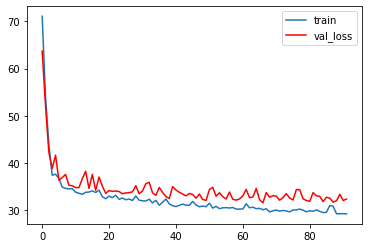

In [42]:
history = hist.history
loss_train = history['loss']
loss_val = history['val_loss']

plt.figure()
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val_loss', color='red')
plt.legend()

Our graph follows the patterns we expect when training deep learning models.

In [43]:
#To finish our model analysis, we'll plot the difference between real and predicted values:

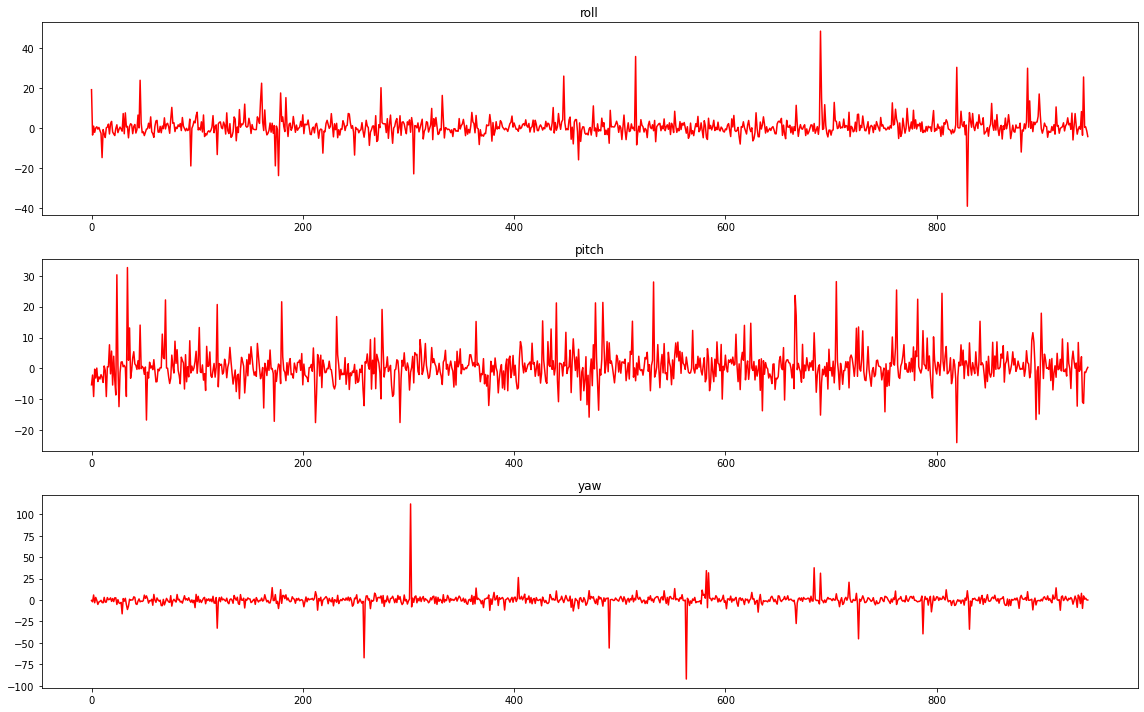

In [45]:
y_pred = model.predict(x_test)
diff = y_test - y_pred
diff_roll = diff[:, 0]
diff_pitch = diff[:, 1]
diff_yaw = diff[:, 2]

plt.figure(figsize=(16, 10))

plt.subplot(3, 1, 1)
plt.plot(diff_roll, color='red')
plt.title('roll')

plt.subplot(3, 1, 2)
plt.plot(diff_pitch, color='red')
plt.title('pitch')

plt.subplot(3, 1, 3)
plt.plot(diff_yaw, color='red')
plt.title('yaw')

plt.tight_layout()

As we can observe, the yaw was the easiest one to our model to predict, followed by roll and pitch. 

### Testing the model 

Now, we will test the model we've just trained.

In [46]:
#define 2 functions:
#detect_face_points -> to get the 68 facial landmarks through the facial landmark model
#computes_featuers  -> to compute the distances amongst the landmarks.

In [47]:
def detect_face_points(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")
    face_rect = detector(image, 1)
    if len(face_rect) != 1: return []
    
    dlib_points = predictor(image, face_rect[0])
    face_points = []
    for i in range(68):
        x, y = dlib_points.part(i).x, dlib_points.part(i).y
        face_points.append(np.array([x, y]))
    return face_points
        
def compute_features(face_points):
    assert (len(face_points) == 68), "len(face_points) must be 68"
    
    face_points = np.array(face_points)
    features = []
    for i in range(68):
        for j in range(i+1, 68):
            features.append(np.linalg.norm(face_points[i]-face_points[j]))
            
    return np.array(features).reshape(1, -1)

 Roll: -5.48°
Pitch: -8.23°
  Yaw: -15.90°


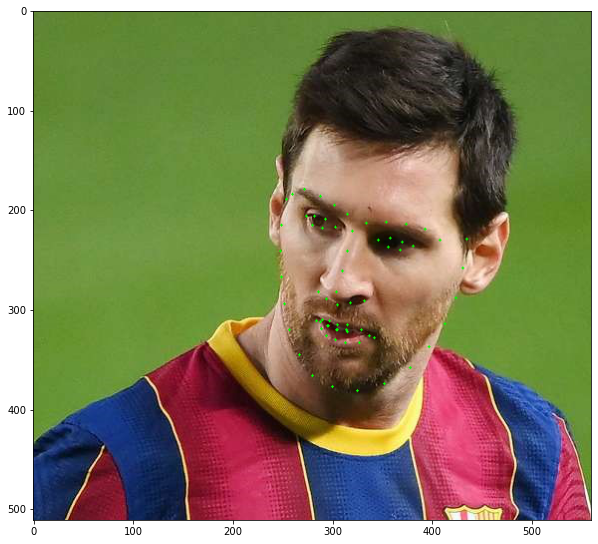

In [48]:
im = cv2.imread('data/messi.jpg', cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
face_points = detect_face_points(im)

for x, y in face_points:
    cv2.circle(im, (x, y), 1, (0, 255, 0), -1)
    
features = compute_features(face_points)
features = std.transform(features)

model = load_model('models/model.h5')
y_pred = model.predict(features)

roll_pred, pitch_pred, yaw_pred = y_pred[0]
print(' Roll: {:.2f}°'.format(roll_pred))
print('Pitch: {:.2f}°'.format(pitch_pred))
print('  Yaw: {:.2f}°'.format(yaw_pred))
    
plt.figure(figsize=(10, 10))
plt.imshow(im)